##### Datos del sujeto P001 en la sesion TEST01

In [3]:
import pandas as pd

# Cargar los datos en un DataFrame
df_P001_EDA_PPT= pd.read_csv('TEST01/E4/P001/EDA_PPT.csv')
df_P001_EDA_RELAX= pd.read_csv('TEST01/E4/P001/EDA_RELAX.csv')


# Mostrar las primeras filas del DataFrame para verificar la carga
df_P001_EDA_PPT.head() 


,Time (s),EDA
0,0.139,0.17678
1,0.389,0.17934
2,0.639,0.17550
3,0.889,0.17550
4,1.139,0.17678


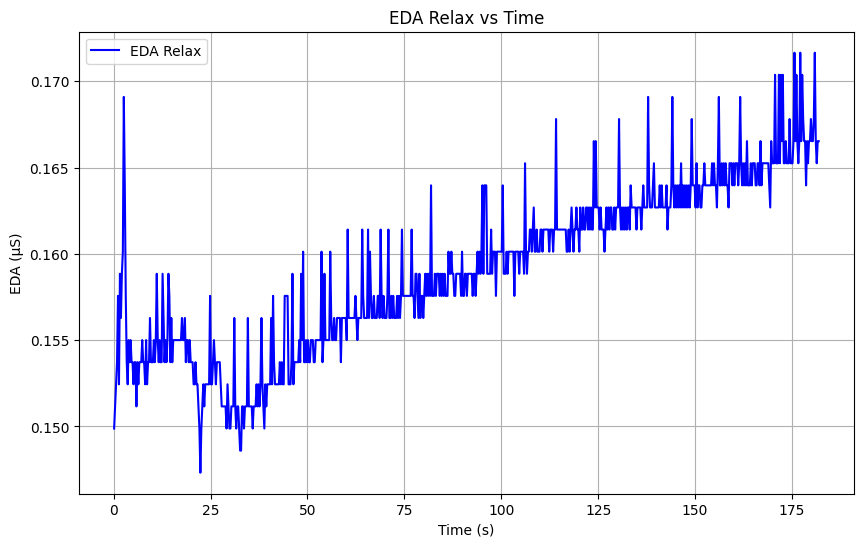

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


# Extraer la columna de tiempo de df_P001_EDA_PPT
time = df_P001_EDA_PPT['Time (s)']

# Extraer la columna EDA de df_P001_EDA_RELAX
eda_relax = df_P001_EDA_RELAX['EDA']

# Asegurarse de que time y eda_relax tengan la misma longitud
min_length = min(len(time), len(eda_relax))
time = time[:min_length]
eda_relax = eda_relax[:min_length]

# Graficar EDA_RELAX contra el tiempo
plt.figure(figsize=(10, 6))
plt.plot(time, eda_relax, label='EDA Relax', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('EDA (μS)')
plt.title('EDA Relax vs Time')
plt.legend()
plt.grid(True)
plt.show()

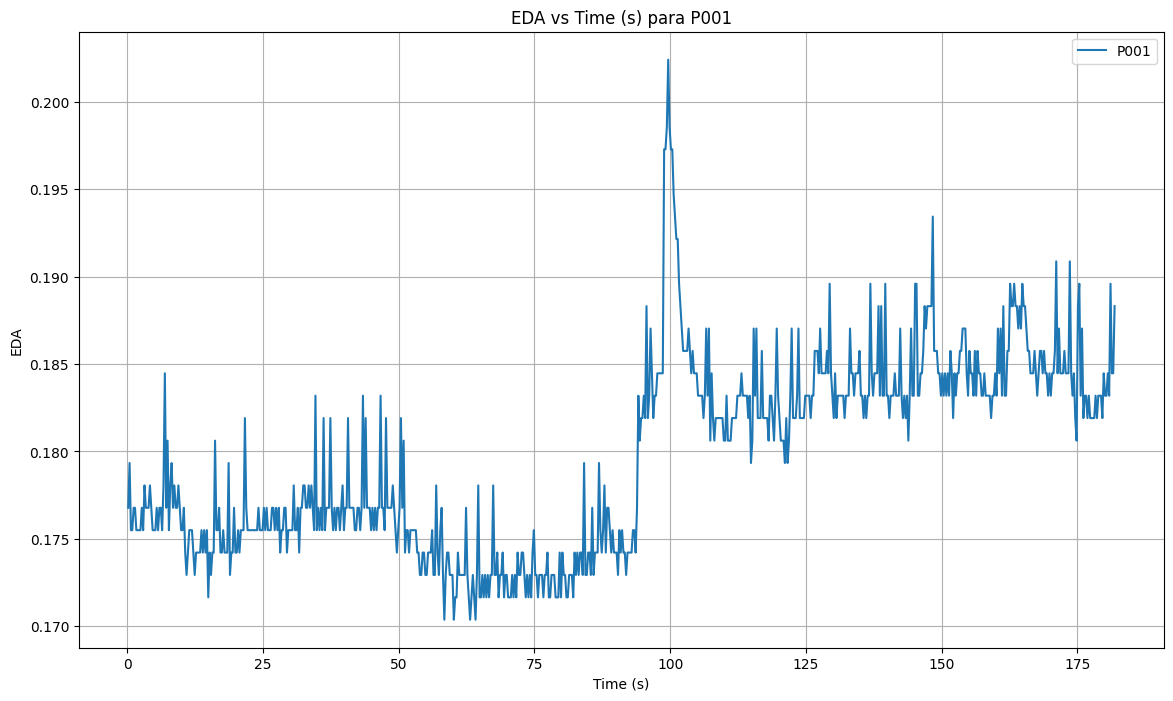

In [5]:
import matplotlib.pyplot as plt

# Graficar EDA vs Time (s) para df_P001_EDA_PPT
plt.figure(figsize=(14, 8))
plt.plot(df_P001_EDA_PPT['Time (s)'], df_P001_EDA_PPT['EDA'], label='P001')

plt.xlabel('Time (s)')
plt.ylabel('EDA')
plt.title('EDA vs Time (s) para P001')
plt.legend()
plt.grid(True)
plt.show()

#### Proceso de desconvolución de las señal

Las señales EDA se componen de dos señales que se combinan (convolucionan), estas son:

Nivel Electrodérmico (ECL o SCL ): Es la señal de base, que varía lentamente a lo largo del tiempo.
Representa la actividad tónica de las glándulas sudoríparas, esta se puede despreciar ya que informa los cambios en la confuctancia electrodérmica en relación con la temperatura y humedad del medio ambiente o el movimiento del cuerpo.

Respuesta Electrodérmica (EDR o SCR): Es una señal que varía rápidamente y está estrechamente relacionada con el sistema nervioso simpático (SNS) encargado de preparar el cuerpo para afrontar situaciones de estres. 

Por lo tanto es necesario descomponer la señal EDA para poder aislar los datos obtenidos de señal SCR la cual varía directamente con el estres.

#### Uso de la función cvxEDA

La función `cvxEDA` es proporcionada por Luca Citi y Alberto Greco. Puedes encontrar más información en [este enlace](https://github.com/lciti/cvxEDA/tree/master).

##### Instalación de la dependencia

Para utilizar `cvxEDA`, es necesario instalar la dependencia `cvxopt`. 
Ejecutando el siguiente comando:

pip install cvxopt


     pcost       dcost       gap    pres   dres
 0: -1.1763e+01 -1.1181e+01  7e+02  3e+01  6e-01
 1: -1.1192e+01 -4.1705e+01  3e+01  1e+00  2e-02
 2: -1.1191e+01 -1.2347e+01  1e+00  2e-02  5e-04
 3: -1.1603e+01 -1.1765e+01  2e-01  2e-04  5e-06
 4: -1.1747e+01 -1.1763e+01  2e-02  2e-05  4e-07
 5: -1.1760e+01 -1.1762e+01  2e-03  2e-07  4e-09
 6: -1.1762e+01 -1.1762e+01  3e-04  2e-08  3e-10
 7: -1.1762e+01 -1.1762e+01  3e-05  8e-10  2e-11
 8: -1.1762e+01 -1.1762e+01  2e-06  5e-11  1e-12
 9: -1.1762e+01 -1.1762e+01  5e-08  6e-13  1e-14
Optimal solution found.


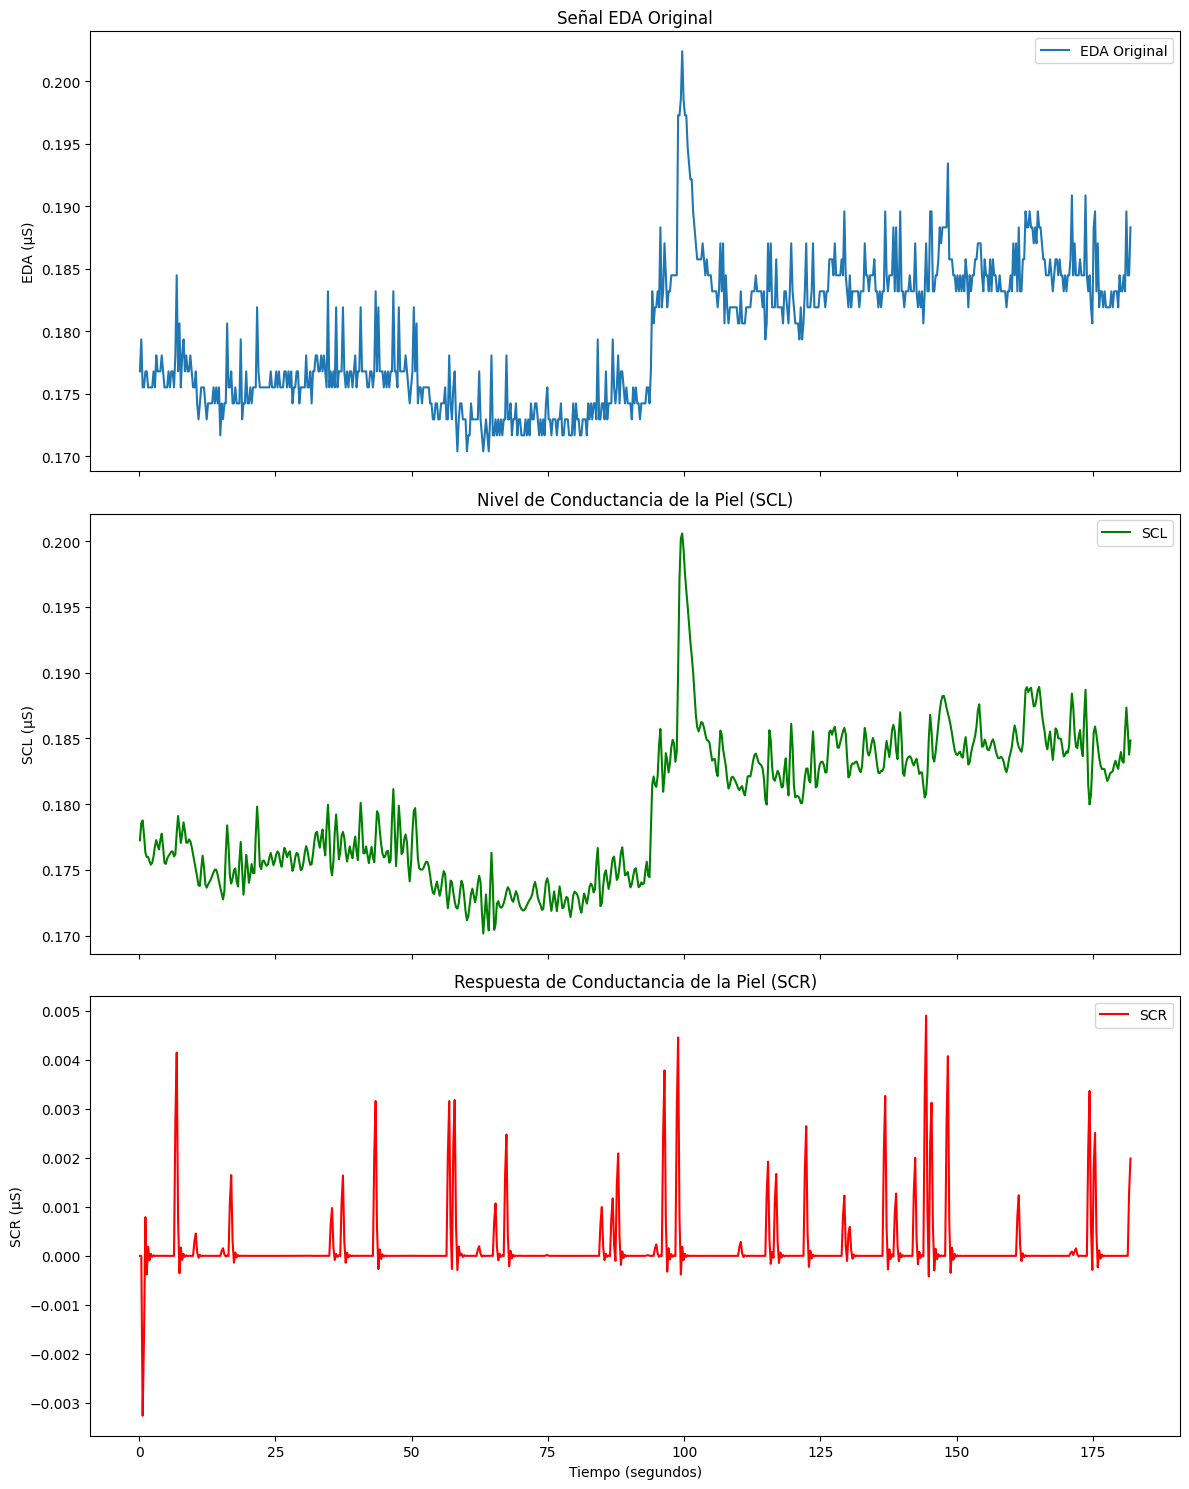

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from cvxEDA import cvxEDA

# Preparar los datos para cvxEDA
y = df_P001_EDA_PPT['EDA'].values
t = df_P001_EDA_PPT['Time (s)'].values
dt = np.mean(np.diff(t))  # Intervalo de muestreo promedio

# Realizar la desconvolución
[r, p, t, l, d, e, obj] = cvxEDA(y, 1./dt)

# Crear un nuevo DataFrame con los resultados
results_P001 = pd.DataFrame({
    'time': df_P001_EDA_PPT['Time (s)'],
    'original_EDA': y,
    'SCL': t,  # Componente tónica (Skin Conductance Level)
    'SCR': r,  # Componente fásica (Skin Conductance Response)
})

# Crear la figura con tres subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Graficar EDA original
ax1.plot(results_P001['time'], results_P001['original_EDA'], label='EDA Original')
ax1.set_title('Señal EDA Original')
ax1.set_ylabel('EDA (μS)')
ax1.legend()

# Graficar SCL (componente tónica)
ax2.plot(results_P001['time'], results_P001['SCL'], label='SCL', color='green')
ax2.set_title('Nivel de Conductancia de la Piel (SCL)')
ax2.set_ylabel('SCL (μS)')
ax2.legend()

# Graficar SCR (componente fásica)
ax3.plot(results_P001['time'], results_P001['SCR'], label='SCR', color='red')
ax3.set_title('Respuesta de Conductancia de la Piel (SCR)')
ax3.set_xlabel('Tiempo (segundos)')
ax3.set_ylabel('SCR (μS)')
ax3.legend()

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

# Opcional: Guardar los resultados en un nuevo archivo CSV
results_P001.to_csv('deconvolved_EDA.csv', index=False)

#### Definición del estado como "estresado" o "no estresado"

Se consideran los reportes autodescriptivos de los participantes, como esta es la señal en el momento en que se da el discurso, se considerará el reporte TEST01_afterPPT que fue respondido luego de realizar el discurso.

Se considera el campo State Anxiety Enthusiasm Score para determinar si la persona estuvo estresada o no durante el discurso.

Por lo que es necesario definir un umbral para realizar una determinación binaria que indique si la persona estuvo estresada o no.


##### Definición del umbral de State Anxiety Enthusiasm
Gráfico de distribución de los datos.


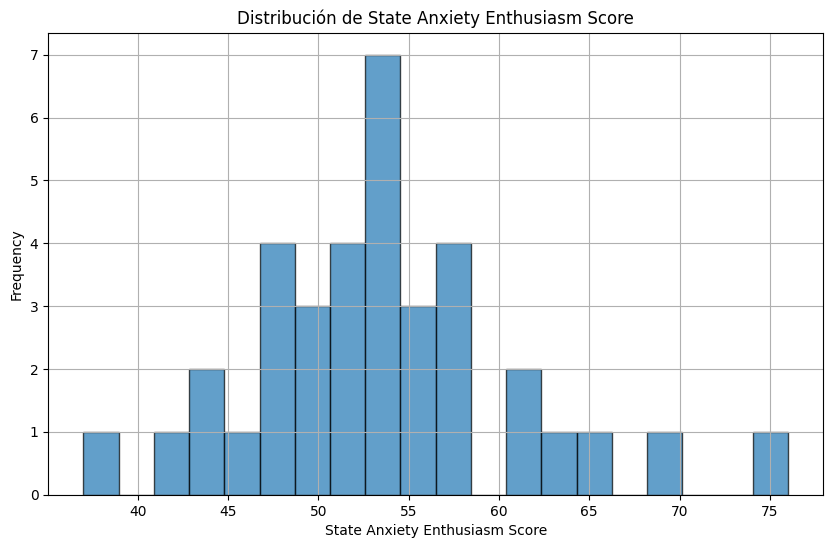

In [7]:
import pandas as pd

import matplotlib.pyplot as plt

# Cargar los datos del archivo CSV
df_self_reports = pd.read_csv('TEST01/Self_Reports/TEST01_afterPPT.csv')

# Graficar la distribución de "State Anxiety Enthusiasm Score"
plt.figure(figsize=(10, 6))
plt.hist(df_self_reports['State Anxiety Enthusiasm Score'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('State Anxiety Enthusiasm Score')
plt.ylabel('Frequency')
plt.title('Distribución de State Anxiety Enthusiasm Score')
plt.grid(True)
plt.show()

Se calcula el rango intercuartílico (IQR), que es la diferencia entre el percentil 75 y el percentil 25. 
Esto mide la dispersión de los datos.
Si el IQR es mayor que la diferencia entre el percentil 75 y el puntaje mínimo, se selecciona el percentil 75 como umbral, lo que indica que los valores por encima de este percentil se consideran de personas no estresadas.
De lo contrario, se selecciona el percentil 25 como umbral, y los valores por debajo de este se consideran de personas estresadas.


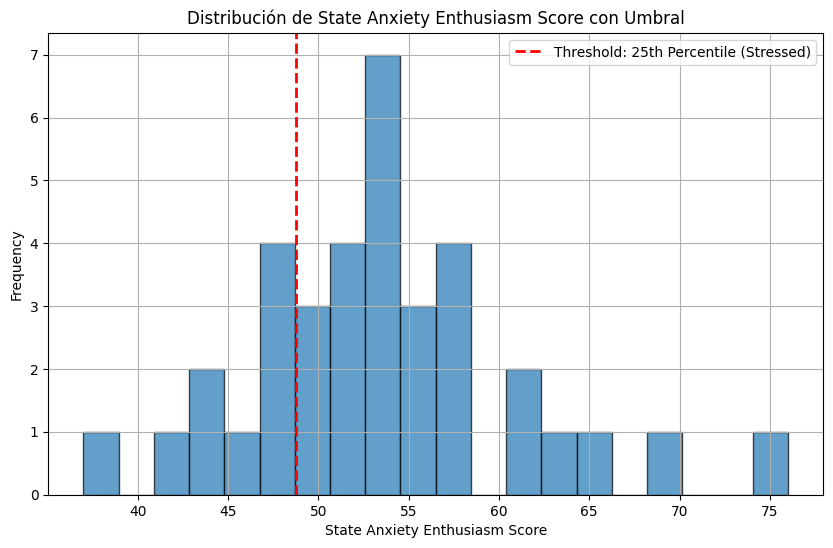

In [8]:

# Calcular los percentiles
percentile_75 = df_self_reports['State Anxiety Enthusiasm Score'].quantile(0.75)
percentile_25 = df_self_reports['State Anxiety Enthusiasm Score'].quantile(0.25)

# Determinar el mejor umbral basado en la dispersión de los datos
iqr = percentile_75 - percentile_25
if iqr > (percentile_75 - df_self_reports['State Anxiety Enthusiasm Score'].min()):
    best_threshold = percentile_75
    threshold_label = '75th Percentile (Non-Stressed)'
else:
    best_threshold = percentile_25
    threshold_label = '25th Percentile (Stressed)'

# Graficar la distribución con el umbral
plt.figure(figsize=(10, 6))
plt.hist(df_self_reports['State Anxiety Enthusiasm Score'], bins=20, edgecolor='k', alpha=0.7)
plt.axvline(best_threshold, color='r', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold_label}')
plt.xlabel('State Anxiety Enthusiasm Score')
plt.ylabel('Frequency')
plt.title('Distribución de State Anxiety Enthusiasm Score con Umbral')
plt.legend()
plt.grid(True)
plt.show()

Se agrega el nuevo campo stressed dependiendo si el el valor de su encuesta es superior a best_threshold se considerará como estresado

In [9]:
print(best_threshold)
# Crear una nueva columna 'stressed' basada en el umbral
df_self_reports['stressed'] = df_self_reports['State Anxiety Enthusiasm Score'].apply(lambda x: 1 if x >= best_threshold else 0)

# Crear un nuevo DataFrame con las columnas requeridas
df_stress_status = df_self_reports[['PID', 'State Anxiety Enthusiasm Score', 'stressed']]

df_stress_status.head()

48.75


,PID,State Anxiety Enthusiasm Score,stressed
0,P001,54,1
1,P004,53,1
2,P005,48,0
3,P008,58,1
4,P013,54,1


##### Considerando el umbral obtener el estado de estresado o no del participante de P001:



In [10]:
stress_P001_value = df_stress_status.loc[df_stress_status['PID'] == 'P001', 'stressed'].values[0]
print(stress_P001_value)


1


##### Segmentar la señal del participante P001 en ventanas de 30 segundos 

In [11]:
# Definir el tamaño de la ventana en segundos
window_size = 30
# Crear una columna para identificar cada ventana
results_P001['window'] = (results_P001['time'] // window_size).astype(int)

# Agrupar por ventana y calcular estadísticas
segmented_results = results_P001.groupby('window').agg({
    'time': ['min', 'max'],
    'original_EDA': ['mean', 'std'],
    'SCL': ['mean', 'std'],
    'SCR': ['mean', 'std']
}).reset_index()

# Renombrar las columnas para mayor claridad
segmented_results.columns = [
    'window', 'start_time', 'end_time', 
    'mean_original_EDA', 'std_original_EDA', 
    'mean_SCL', 'std_SCL', 
    'mean_SCR', 'std_SCR'
]

# Mostrar los resultados segmentados
segmented_results.head()

,window,start_time,end_time,mean_original_EDA,std_original_EDA,mean_SCL,std_SCL,mean_SCR,std_SCR
0,0,0.139,29.889,0.175873,0.001760,0.175806,0.001357,0.000059,0.000604
1,1,30.139,59.889,0.176247,0.002311,0.176063,0.001937,0.000182,0.000625
2,2,60.139,89.889,0.173271,0.001712,0.173173,0.001282,0.000119,0.000401
3,3,90.139,119.889,0.183380,0.005537,0.183194,0.005330,0.000183,0.000687
4,4,120.139,149.889,0.184128,0.002387,0.183782,0.001817,0.000344,0.000909


Agregar el valor de stressed en las ventanas:


In [12]:
segmented_results["stressed"] = stress_P001_value
segmented_results.head(1)

,window,start_time,end_time,mean_original_EDA,std_original_EDA,mean_SCL,std_SCL,mean_SCR,std_SCR,stressed
0,0,0.139,29.889,0.175873,0.00176,0.175806,0.001357,0.000059,0.000604,1


#### Carga de los datos de todos los participantes de la sesion TEST01 A TEST08

In [42]:
import os

# Lista de carpetas de prueba
test_folders = [f'TEST0{i}' for i in range(1, 9)]

# Lista para almacenar los DataFrames de cada prueba
df_list = []

for test_folder in test_folders:
    # Cargar los datos de los participantes
    pid_participants = pd.read_csv(f'{test_folder}/participant_id.csv')
    
    for pid in pid_participants["PID"]:
        file_path = f'{test_folder}/E4/{pid}/EDA_PPT.csv'
        if os.path.exists(file_path):
            df_pid = pd.read_csv(file_path)
            df_pid['PID'] = pid  # Añadir una columna para identificar el PID
            df_pid['Test'] = test_folder  # Añadir una columna para identificar la prueba
            df_list.append(df_pid)

# Concatenar todos los DataFrames en uno solo
df_all_tests_EDA_PPT = pd.concat(df_list, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado para verificar la carga
df_all_tests_EDA_PPT.head()

,Time (s),EDA,PID,Test
0,0.139,0.17678,P001,TEST01
1,0.389,0.17934,P001,TEST01
2,0.639,0.17550,P001,TEST01
3,0.889,0.17550,P001,TEST01
4,1.139,0.17678,P001,TEST01


Contabilizar la cantidad de participantes

In [47]:
unique_pid_count = pid_participants['PID'].nunique()
print(f"Cantidad de PID diferentes: {unique_pid_count}")
df_all_tests_EDA_PPT.head(3)


Cantidad de PID diferentes: 29


,Time (s),EDA,PID,Test
0,0.139,0.17678,P001,TEST01
1,0.389,0.17934,P001,TEST01
2,0.639,0.17550,P001,TEST01


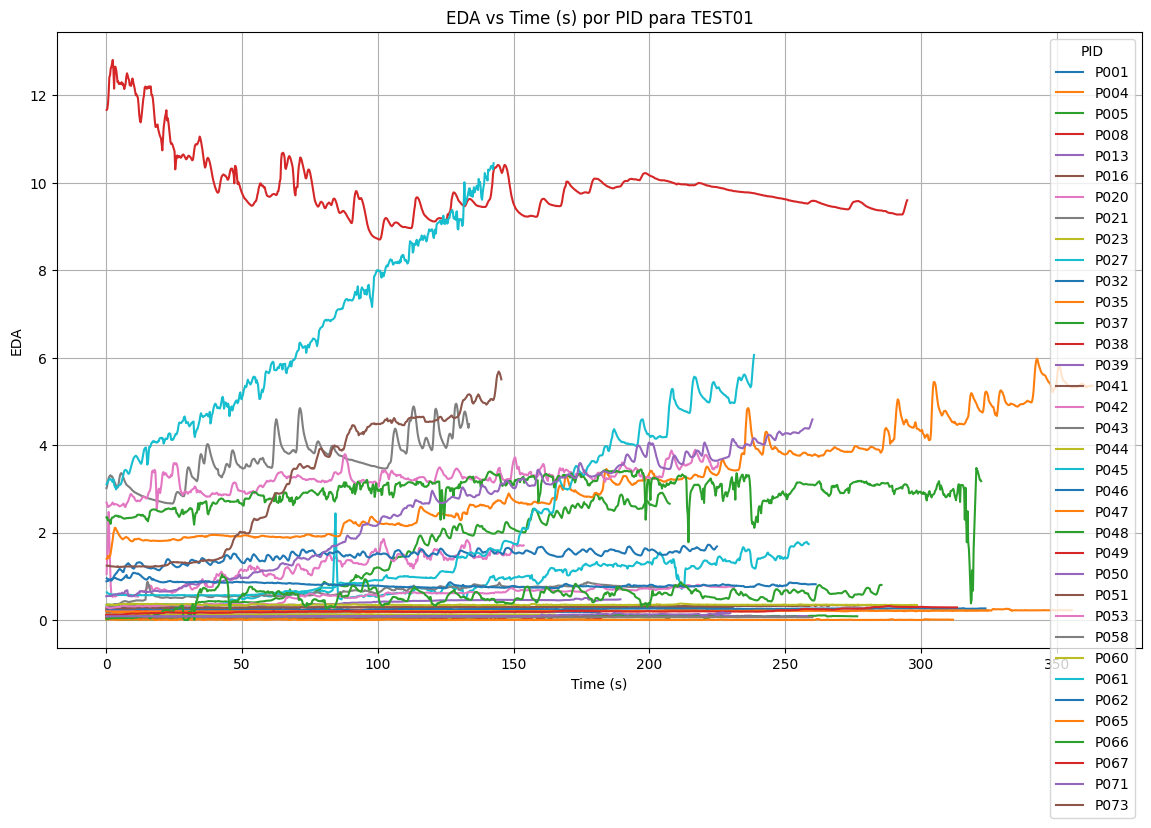

In [48]:
import matplotlib.pyplot as plt

# Filtrar los datos para incluir solo TEST01
df_test01_EDA_PPT = df_all_tests_EDA_PPT[df_all_tests_EDA_PPT['Test'] == 'TEST01']

# Graficar EDA vs Time (s) por PID para TEST01
plt.figure(figsize=(14, 8))

# Obtener los PIDs únicos para TEST01
unique_pids_test01 = df_test01_EDA_PPT['PID'].unique()

# Graficar cada PID con un color diferente
for pid in unique_pids_test01:
    df_pid = df_test01_EDA_PPT[df_test01_EDA_PPT['PID'] == pid]
    plt.plot(df_pid['Time (s)'], df_pid['EDA'], label=pid)

plt.xlabel('Time (s)')
plt.ylabel('EDA')
plt.title('EDA vs Time (s) por PID para TEST01')
plt.legend(title='PID')
plt.grid(True)
plt.show()

##### Desconvolucion de todos los datos de TEST01

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxEDA import cvxEDA

# Crear una lista para almacenar los resultados de cada PID y Test
results_list = []

# Obtener las combinaciones únicas de PID y Test
unique_combinations = df_all_tests_EDA_PPT[['PID', 'Test']].drop_duplicates()

# Realizar la desconvolución para cada combinación de PID y Test y almacenar los resultados
for _, row in unique_combinations.iterrows():
    pid = row['PID']
    test = row['Test']
    df_pid_test = df_all_tests_EDA_PPT[(df_all_tests_EDA_PPT['PID'] == pid) & (df_all_tests_EDA_PPT['Test'] == test)]
    
    # Preparar los datos para cvxEDA
    y = df_pid_test['EDA'].values
    t = df_pid_test['Time (s)'].values
    dt = np.mean(np.diff(t))  # Intervalo de muestreo promedio

    # Realizar la desconvolución
    [r, p, t, l, d, e, obj] = cvxEDA(y, 1./dt)

    # Crear un nuevo DataFrame con los resultados
    results = pd.DataFrame({
        'time': df_pid_test['Time (s)'],
        'original_EDA': y,
        'SCL': t,  # Componente tónica (Skin Conductance Level)
        'SCR': r,  # Componente fásica (Skin Conductance Response)
        'PID': pid,  # Añadir una columna para identificar el PID
        'Test': test  # Añadir una columna para identificar el Test
    })
    
    # Añadir los resultados a la lista
    results_list.append(results)

# Concatenar todos los resultados en un solo DataFrame
all_results = pd.concat(results_list, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado
all_results.head(3)

# Opcional: Guardar los resultados en un nuevo archivo CSV
# all_results.to_csv('deconvolved_EDA_all_PIDs_Tests.csv', index=False)

     pcost       dcost       gap    pres   dres
 0: -1.1763e+01 -1.1181e+01  7e+02  3e+01  6e-01
 1: -1.1192e+01 -4.1705e+01  3e+01  1e+00  2e-02
 2: -1.1191e+01 -1.2347e+01  1e+00  2e-02  5e-04
 3: -1.1603e+01 -1.1765e+01  2e-01  2e-04  5e-06
 4: -1.1747e+01 -1.1763e+01  2e-02  2e-05  4e-07
 5: -1.1760e+01 -1.1762e+01  2e-03  2e-07  4e-09
 6: -1.1762e+01 -1.1762e+01  3e-04  2e-08  3e-10
 7: -1.1762e+01 -1.1762e+01  3e-05  8e-10  2e-11
 8: -1.1762e+01 -1.1762e+01  2e-06  5e-11  1e-12
 9: -1.1762e+01 -1.1762e+01  5e-08  6e-13  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.0233e+01 -2.9092e+01  1e+03  4e+01  4e-01
 1: -2.9127e+01 -8.8761e+01  6e+01  2e+00  2e-02
 2: -2.9121e+01 -3.1459e+01  2e+00  3e-02  3e-04
 3: -2.9902e+01 -3.0237e+01  3e-01  3e-04  3e-06
 4: -3.0204e+01 -3.0232e+01  3e-02  3e-05  3e-07
 5: -3.0227e+01 -3.0232e+01  5e-03  3e-07  3e-09
 6: -3.0231e+01 -3.0232e+01  9e-04  3e-08  3e-10
 7: -3.0231e+01 -3.0231e+01  1e-04  2e-09  1e-1

,time,original_EDA,SCL,SCR,PID,Test
0,0.139,0.17678,0.177249,0.000000,P001,TEST01
1,0.389,0.17934,0.178575,0.000000,P001,TEST01
2,0.639,0.17550,0.178761,-0.003261,P001,TEST01


##### Creacion de ventanas de  30 segundos


In [51]:
# Definir el tamaño de la ventana en segundos
window_size = 30

# Crear una columna para identificar cada ventana
all_results['window'] = (all_results['time'] // window_size).astype(int)
all_results.head(1)


,time,original_EDA,SCL,SCR,PID,Test,window
0,0.139,0.17678,0.177249,0.0,P001,TEST01,0


##### Agregar caracteristicas :
Feature Vector = [meanEDA, minEDA, maxEDA, stdEDA, meanSCRonsets, meanSCRamp, meanSCRrecovery ]

In [53]:
# Agrupar por ventana y calcular estadísticas
segmented_results = all_results.groupby(['PID', 'Test', 'window']).agg({
    'time': ['min', 'max'],
    'original_EDA': ['mean', 'std'],
    'SCL': ['mean', 'std'],
    'SCR': ['mean', 'std']
}).reset_index()

# Renombrar las columnas para mayor claridad
segmented_results.columns = [
    'PID', 'Test', 'window', 'start_time', 'end_time', 
    'mean_original_EDA', 'std_original_EDA', 
    'mean_SCL', 'std_SCL', 
    'mean_SCR', 'std_SCR'
]

# Mostrar los resultados segmentados
segmented_results.head()

,PID,Test,window,start_time,end_time,mean_original_EDA,std_original_EDA,mean_SCL,std_SCL,mean_SCR,std_SCR
0,P001,TEST01,0,0.139,29.889,0.175873,0.001760,0.175806,0.001357,0.000059,0.000604
1,P001,TEST01,1,30.139,59.889,0.176247,0.002311,0.176063,0.001937,0.000182,0.000625
2,P001,TEST01,2,60.139,89.889,0.173271,0.001712,0.173173,0.001282,0.000119,0.000401
3,P001,TEST01,3,90.139,119.889,0.183380,0.005537,0.183194,0.005330,0.000183,0.000687
4,P001,TEST01,4,120.139,149.889,0.184128,0.002387,0.183782,0.001817,0.000344,0.000909


Contabilizar la cantidad de ventanas

In [58]:
count_test01_windows = segmented_results[segmented_results['Test'] == 'TEST01'].shape[0]
print(f"Cantidad de ventanas para TEST01: {count_test01_windows}")
print(f"Cantidad de ventanas: {len(segmented_results)}")

Cantidad de ventanas para TEST01: 310
Cantidad de ventanas: 2032
